In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import open3d as o3d
from torch.utils.data import Dataset, DataLoader, Subset
from dataclasses import dataclass
import sys
from pathlib import Path
from pytorch3d.loss import chamfer_distance
from tqdm import tqdm
import autoencoders as ae


sys.path.append(str(Path.cwd().parent))

from Helpers.data import PointCloudDataset
import Helpers.PointCloudOpen3d as pc

if torch.cuda.is_available():
    device = "cuda"

elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f'Using: {device}')


# train_dataset_3072 = PointCloudDataset("../Data/ModelNet40", 3072, 'train', object_classes = None )
# test_dataset_3072 = PointCloudDataset("../Data/ModelNet40", 3072, 'test', object_classes = None)

# test_size = len(test_dataset_3072)
# split_idx = test_size // 2
# indices = list(range(test_size))
# val_dataset_3072 = Subset(test_dataset_3072, indices[:split_idx])
# test_dataset_3072 = Subset(test_dataset_3072, indices[split_idx:])

# train_loader_3072 = DataLoader(train_dataset_3072, batch_size = 64, shuffle = True)
# val_loader_3072 = DataLoader(val_dataset_3072, batch_size = 128, shuffle = False)
# test_loader_3072 = DataLoader(test_dataset_3072, batch_size = 128, shuffle = False)

train_dataset_1024 = PointCloudDataset("../Data/ModelNet40", 1024, 'train', object_classes =  None )
test_dataset_1024 = PointCloudDataset("../Data/ModelNet40", 1024, 'test', object_classes =  None)

test_size = len(test_dataset_1024)
split_idx = test_size // 2
indices = list(range(test_size))
val_dataset_1024 = Subset(test_dataset_1024, indices[:split_idx])
test_dataset_1024 = Subset(test_dataset_1024, indices[split_idx:])

train_loader_1024= DataLoader(train_dataset_1024, batch_size = 64, shuffle = True)
val_loader_1024 = DataLoader(val_dataset_1024, batch_size = 128, shuffle = False)
test_loader_1024 = DataLoader(test_dataset_1024, batch_size = 128, shuffle = False)


train_dataset_1024_unord = PointCloudDataset("../Data/ModelNet40", 1024, 'train', object_classes =  None, order_points= False)
test_dataset_1024_unord  = PointCloudDataset("../Data/ModelNet40", 1024, 'test', object_classes =  None, order_points= False)

test_size = len(test_dataset_1024_unord )
split_idx = test_size // 2
indices = list(range(test_size))
val_dataset_1024_unord  = Subset(test_dataset_1024_unord , indices[:split_idx])
test_dataset_1024_unord  = Subset(test_dataset_1024_unord , indices[split_idx:])

train_loader_1024_unord = DataLoader(train_dataset_1024_unord , batch_size = 64, shuffle = True)
val_loader_1024_unord  = DataLoader(val_dataset_1024_unord , batch_size = 128, shuffle = False)
test_loader_1024_unord  = DataLoader(test_dataset_1024_unord , batch_size = 128, shuffle = False)

Using: cuda


In [17]:
def train_model(key, model, num_epochs, train_loader, val_loader, size):

    optimizer = optim.AdamW(model.parameters(), lr=0.0001)

    min_val_loss = np.inf

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):

        # Train one epoch
        train_loss = 0 

        for data in train_loader:
            
            x = data['points'].to(device)

            reconstructed_x = model(x.permute(0,2,1)) # Model expects point clouds to be (3, num_points)
            optimizer.zero_grad()
            loss, _ = chamfer_distance(x, reconstructed_x)

            loss.backward()

            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Calculate validation loss

        val_loss = 0 

        for data in val_loader:

            x = data['points'].to(device)

            with torch.no_grad():
                reconstructed_x = model(x.permute(0,2,1))
                loss, _ = chamfer_distance(x, reconstructed_x)
                val_loss+= loss.item()

        val_loss /= len(val_loader)

        # print(f'\nEpoch {epoch+1} \t Train Loss: {train_loss:.5f} \t Val Loss: {val_loss:.5f}')

        # Save best model
        if val_loss < min_val_loss:
            # print(f'Val Loss Decreased({min_val_loss:.6f} ---> {val_loss:.6f}) \t Saving The Model')
            min_val_loss = val_loss

            torch.save(model.state_dict(), f'./trained_autoencoders/{size}/{key}')

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses


In [19]:
num_epochs = 100
latent_size = 256
point_size = 1024

c_model_ord = ae.ConvAE_800T(point_size, latent_size).to(device)
c_model_unord = ae.ConvAE_800T(point_size, latent_size).to(device)

c_train_losses_ord, c_val_losses_ord = train_model('c_ord', c_model_ord, num_epochs, train_loader_1024, val_loader_1024, '1024_256')
c_train_losses_unord, c_val_losses_unord = train_model('c_unord', c_model_unord, num_epochs, train_loader_1024_unord, val_loader_1024_unord, '1024_256')

mlp_model_ord = ae.MLP_AE(point_size, latent_size).to(device)
mlp_model_unord = ae.MLP_AE(point_size, latent_size).to(device)

mlp_train_losses_ord, mlp_val_losses_ord = train_model('ord', mlp_model_ord, num_epochs, train_loader_1024, val_loader_1024, '1024_256')
mlp_train_losses_unord, mlp_val_losses_unord = train_model('unord', mlp_model_unord, num_epochs, train_loader_1024_unord, val_loader_1024_unord, '1024_256')

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


Text(0.5, 1.0, 'Ordered vs Unordered point clouds')

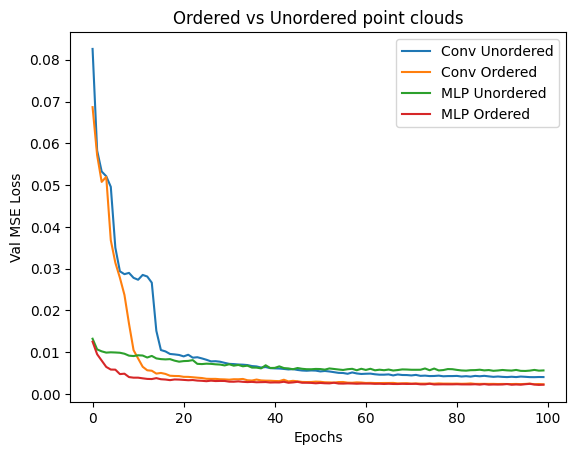

In [76]:
plt.plot(c_val_losses_unord, label = 'Conv Unordered')
plt.plot(c_val_losses_ord, label = 'Conv Ordered')
plt.plot(mlp_val_losses_unord, label = 'MLP Unordered')
plt.plot(mlp_val_losses_ord, label = 'MLP Ordered')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Val MSE Loss")
plt.title("Ordered vs Unordered point clouds")

In [75]:
def visualize_random_reconstruction(model, x, device, transpose_out = False, show_org = True):
    '''
    Pick a random cloud from the dataset and show what it looks like before and after autoencoder reconstruction 
    First window is original point cloud 
    Second window is recontructed point cloud
    '''

    def show_cloud(x):
        pc.visualize_point_cloud(pc.get_point_cloud(x))

    
    if show_org:
        show_cloud(x)

    with torch.no_grad():
        x = x.unsqueeze(0).permute(0,2,1).to(device)
        
        rec_x = model(x)[0].to('cpu')
        
        if transpose_out:
            rec_x = rec_x.T
        
        rec_x = np.array(rec_x)

        show_cloud(rec_x)

num = 450
val_loader = DataLoader(val_dataset_1024_unord, batch_size = 1233, shuffle = False)
x = next(iter(val_loader))['points'][num]

visualize_random_reconstruction(c_model_unord, x, device, show_org = True)

val_loader = DataLoader(val_dataset_1024, batch_size = 1233, shuffle = False)
x = next(iter(val_loader))['points'][num]
visualize_random_reconstruction(c_model_ord, x, device, show_org= False)


In [ ]:
# Plot Results 


# Visualize difference between two



In [ ]:
# Load best autoencoder 



In [3]:
### Experiment 3072
num_epochs = 300
point_size = 3072 
latent_size = 512

models = {
    'ConvMax' : ae.ConvMax_AE,
    'ConvOnly' : ae.ConvOnly_AE,
    'MLP' : ae.MLP_AE,
    'Conv_7500T' : ae.ConvAE_7500T,
    'Conv_6800T' : ae.ConvAE_6800T,
    'Conv_6300T' : ae.ConvAE_6300T,
    'Conv_1600T' : ae.ConvAE_1600T,
    'Conv_800T' : ae.ConvAE_800T,
    'Conv_270T' : ae.ConvAE_270T,
}

training_results_3072 = {}


for key in models.keys(): 

    print(f'Training {key} model')
    
    model = models[key](point_size, latent_size).to(device)

    train_losses, val_losses = train_model(key, model, num_epochs, train_loader_3072, val_loader_3072, '3072_512')
    
    training_results_3072[key] = {'train_losses' : train_losses, 'val_losses' : val_losses}

import json
with open('./results/3072_512.json', 'w') as f:
    json.dump(training_results_3072, f)

Training ConvMax model


100%|██████████| 300/300 [12:04<00:00,  2.41s/it]


Training ConvOnly model


100%|██████████| 300/300 [16:05<00:00,  3.22s/it]


Training MLP model


100%|██████████| 300/300 [08:18<00:00,  1.66s/it]


Training Conv_7500T model


100%|██████████| 300/300 [14:04<00:00,  2.82s/it]


Training Conv_6800T model


100%|██████████| 300/300 [12:28<00:00,  2.50s/it]


Training Conv_6300T model


100%|██████████| 300/300 [12:10<00:00,  2.44s/it]


Training Conv_1600T model


100%|██████████| 300/300 [11:13<00:00,  2.24s/it]


Training Conv_800T model


100%|██████████| 300/300 [11:11<00:00,  2.24s/it]


Training Conv_270T model


100%|██████████| 300/300 [11:21<00:00,  2.27s/it]


In [4]:
### Experiment 1024
num_epochs = 300
point_size = 1024
latent_size = 256

models = {
    'ConvMax' : ae.ConvMax_AE,
    'ConvOnly' : ae.ConvOnly_AE,
    'MLP' : ae.MLP_AE,
    'Conv_7500T' : ae.ConvAE_7500T,
    'Conv_6800T' : ae.ConvAE_6800T,
    'Conv_6300T' : ae.ConvAE_6300T,
    'Conv_1600T' : ae.ConvAE_1600T,
    'Conv_800T' : ae.ConvAE_800T,
    'Conv_270T' : ae.ConvAE_270T,
}

training_results_1024= {}


for key in models.keys(): 

    print(f'Training {key} model')
    
    model = models[key](point_size, latent_size).to(device)

    train_losses, val_losses = train_model(key, model, num_epochs, train_loader_1024, val_loader_1024, '1024_256')
    
    training_results_1024[key] = {'train_losses' : train_losses, 'val_losses' : val_losses}


import json
with open('./results/1024_256.json', 'w') as f:
    json.dump(training_results_1024, f)
    

Training ConvMax model


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [03:24<00:00,  1.47it/s]


Training ConvOnly model


100%|██████████| 300/300 [08:00<00:00,  1.60s/it]


Training MLP model


100%|██████████| 300/300 [03:15<00:00,  1.54it/s]


Training Conv_7500T model


100%|██████████| 300/300 [05:59<00:00,  1.20s/it]


Training Conv_6800T model


100%|██████████| 300/300 [05:05<00:00,  1.02s/it]


Training Conv_6300T model


100%|██████████| 300/300 [04:46<00:00,  1.05it/s]


Training Conv_1600T model


100%|██████████| 300/300 [04:43<00:00,  1.06it/s]


Training Conv_800T model


100%|██████████| 300/300 [04:42<00:00,  1.06it/s]


Training Conv_270T model


100%|██████████| 300/300 [04:58<00:00,  1.00it/s]


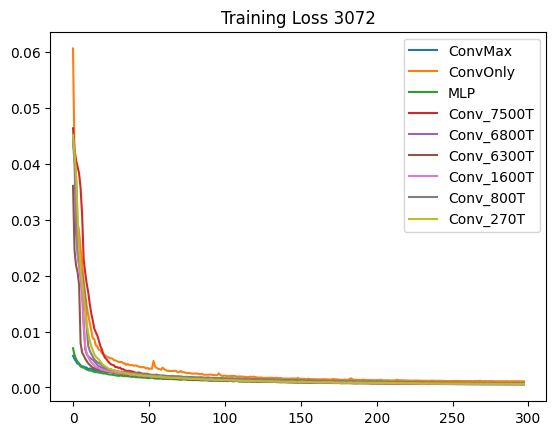

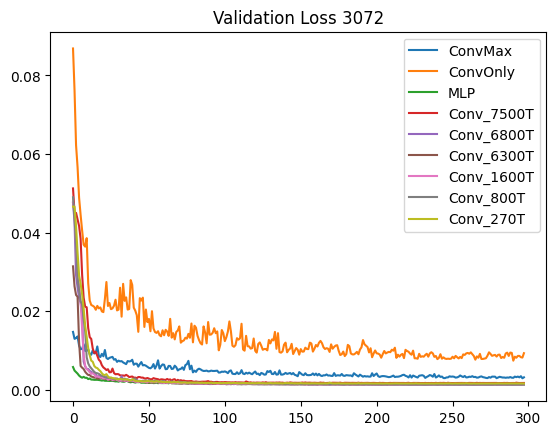

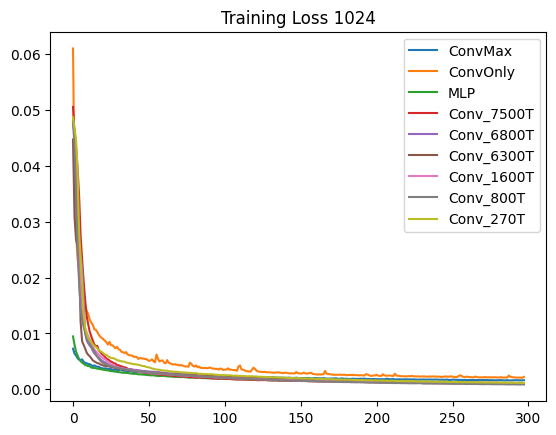

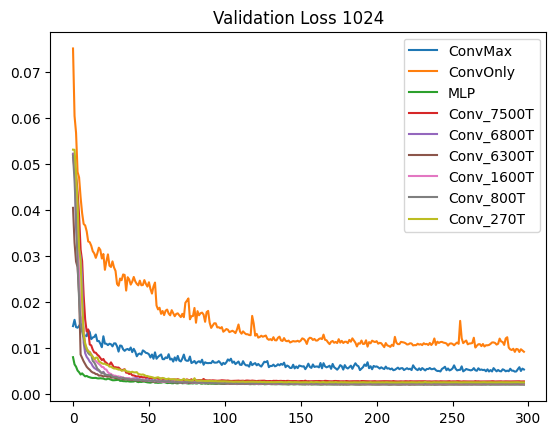

In [5]:
epochs = list(range(num_epochs -2))

for key in training_results_3072.keys():
    plt.plot(epochs, training_results_3072[key]['train_losses'][2:], label = key)

plt.title('Training Loss 3072')
plt.legend()
plt.show()


for key in training_results_3072.keys():
    plt.plot(epochs, training_results_3072[key]['val_losses'][2:], label = key)

plt.title('Validation Loss 3072')
plt.legend()
plt.show()

for key in training_results_1024.keys():
    plt.plot(epochs, training_results_1024[key]['train_losses'][2:], label = key)

plt.title('Training Loss 1024')
plt.legend()
plt.show()


for key in training_results_1024.keys():
    plt.plot(epochs, training_results_1024[key]['val_losses'][2:], label = key)

plt.title('Validation Loss 1024')
plt.legend()
plt.show()

In [7]:
import json
with open('./results/1024_256.json', 'r') as f:
    d1 = json.load(f)

with open('./results/3072_512.json', 'r') as f:
    d3 = json.load(f)

In [24]:
print('Best Val Loss | Point size 1024 | Latent Size 256\n')
for key in d1.keys():   
    print( f'{key: <12} {round(min(d1[key]["val_losses"]), 6)}')
print('\n')
print('Val Loss | Point size 3072 | Latent Size 512\n')
for key in d3.keys():   
    print( f'{key: <12} {round(min(d3[key]["val_losses"]), 6)}')

Best Val Loss | Point size 1024 | Latent Size 256

ConvMax      0.004846
ConvOnly     0.009114
MLP          0.002056
Conv_7500T   0.002688
Conv_6800T   0.002105
Conv_6300T   0.002052
Conv_1600T   0.002193
Conv_800T    0.002209
Conv_270T    0.002477


Val Loss | Point size 3072 | Latent Size 512

ConvMax      0.002929
ConvOnly     0.007407
MLP          0.001381
Conv_7500T   0.001689
Conv_6800T   0.001347
Conv_6300T   0.001352
Conv_1600T   0.001375
Conv_800T    0.001359
Conv_270T    0.001595


In [23]:
models = {
    'ConvMax' : ae.ConvMax_AE,
    'ConvOnly' : ae.ConvOnly_AE,
    'MLP' : ae.MLP_AE,
    'Conv_7500T' : ae.ConvAE_7500T,
    'Conv_6800T' : ae.ConvAE_6800T,
    'Conv_6300T' : ae.ConvAE_6300T,
    'Conv_1600T' : ae.ConvAE_1600T,
    'Conv_800T' : ae.ConvAE_800T,
    'Conv_270T' : ae.ConvAE_270T,
}




for key in models.keys(): 

    
    model = models[key](3072, 512).to(device)

    total = 0
    for name,param in model.named_parameters():
        if "encoder" in name: 
            total += param.numel()

    print(f'{key : <12} Params: {total} ')

ConvMax      Params: 84416 
ConvOnly     Params: 6886112 
MLP          Params: 21499392 
Conv_7500T   Params: 7534656 
Conv_6800T   Params: 6844144 
Conv_6300T   Params: 6316768 
Conv_1600T   Params: 1624640 
Conv_800T    Params: 834096 
Conv_270T    Params: 273056 


In [42]:
point_size = 3072
latent_size = 512

MLPa = ae.MLP_AE(point_size, latent_size).to(device)
MLPa.load_state_dict(torch.load('./trained_autoencoders/3072_512/MLP', weights_only= True))
MLPa.eval()

Conv_6800T = ae.ConvAE_6800T(point_size, latent_size).to(device)
Conv_6800T.load_state_dict(torch.load('./trained_autoencoders/3072_512/Conv_6800T', weights_only= True))
Conv_6800T.eval()

Conv_6300T = ae.ConvAE_6300T(point_size, latent_size).to(device)
Conv_6300T.load_state_dict(torch.load('./trained_autoencoders/3072_512/Conv_6300T', weights_only= True))
Conv_6300T.eval()

Conv_800T = ae.ConvAE_800T(point_size, latent_size).to(device)
Conv_800T.load_state_dict(torch.load('./trained_autoencoders/3072_512/Conv_800T', weights_only= True))
Conv_800T.eval()

ConvOnly_AE = ae.ConvOnly_AE(point_size, latent_size).to(device)
ConvOnly_AE.load_state_dict(torch.load('./trained_autoencoders/3072_512/ConvOnly', weights_only= True))
ConvOnly_AE.eval()



ConvOnly_AE(
  (encoder): ConvOnlyEncoder(
    (c1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (c2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (c3): Conv1d(128, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (c4): Conv1d(32, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (c5): Conv1d(32, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (c6): Conv1d(32, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (c7): Conv1d(32, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (lin7): Linear(in_features=6144, out_features=1024, bias=True)
    (lin8): Linear(in_features=1024, out_features=512, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [30]:
def visualize_random_reconstruction(model, x, device, transpose_out = False, show_org = True):
    '''
    Pick a random cloud from the dataset and show what it looks like before and after autoencoder reconstruction 
    First window is original point cloud 
    Second window is recontructed point cloud
    '''

    def show_cloud(x):
        pc.visualize_point_cloud(pc.get_point_cloud(x))

    
    if show_org:
        show_cloud(x)

    with torch.no_grad():
        x = x.unsqueeze(0).permute(0,2,1).to(device)
        
        rec_x = model(x)[0].to('cpu')
        
        if transpose_out:
            rec_x = rec_x.T
        
        rec_x = np.array(rec_x)

        show_cloud(rec_x)


In [55]:
val_loader = DataLoader(val_dataset_3072, batch_size = 128, shuffle = True)
x = next(iter(val_loader))['points'][0]

visualize_random_reconstruction(MLPa, x, device)
visualize_random_reconstruction(Conv_6800T, x, device, show_org= False)
visualize_random_reconstruction(Conv_800T, x, device, show_org= False)
visualize_random_reconstruction(ConvOnly_AE, x, device, show_org= False)